# Analyzing NYC High School Data

This notebook represents my work on a guided project, as provided by Dataquest.io.

This project starts with published New York City data on student SAT scores by high school, along with additional demographic data sets. 

These data sets are merged into a single pandas dataframe:
* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance by school
* [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students for each school

New York City has a significant and diverse immigrant population. For this short project we will compare demographic factors such as race, income, and gender with SAT scores to determine whether the SAT exam exhibits potential signs of bias.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import numpy as np
import re

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
# Printing the first 10 (not sorted)correlations over all fields.
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.head(10))

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
Name: sat_score, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN for this comparison since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
survey_fields_with_sat_score = combined[['sat_score'] + survey_fields]

In [12]:
corrs = survey_fields_with_sat_score.corr()['sat_score']

In [13]:
# Show sorted correlations between survey fields and 'sat_score'. This time with sorted values.
corrs = corrs.iloc[1:].sort_values(ascending=False)
corrs

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
eng_t_11      0.036906
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
Name: sat_score, dtype: float64

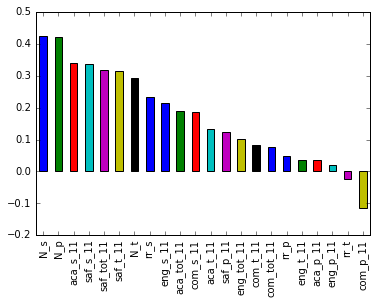

In [14]:
# Visually plot correlations between survey fields and 'sat_score'
corrs.plot.bar()

Here are the specific correlations that are higher than **.3**:
* N_s - The number of student respondents (.42)
* N_p - The number of parent respondents (.42)
* aca_s - Academic expectation scores based on student responses (.33)
* saf_s - Safety and respect scores based on student responses (.33)
* saf_tot - Safety and respect scores based on total responses (.31)
* saf_t - Saftey and respect scores based on teacher response (.31)

It is interesting that the raw number of student and parent respondents would have a relatively high correlation to sat_scores. Larger schools may be better equipped to provide more rigorous sat_score prep services.

Second, we see a connection between student academic expectations and sat_scores. We think of better schools as driving higher sat_scores, when it may be that more engaged students are themselves driving the scores upward.

Third, we see a general relation between school 'safety and respect scores' and sat_scores. When fundamental student needs are not addressed, there is a drag on student sat_scores.

# Investigate perceived safety scores
Safety scores *(saf_t, saf_s)* have an oversize bearing on sat_scores. We will now dig into this relationship to determine which schools have low safety scores. First, let us take a look at the relationship in a scatterplot.

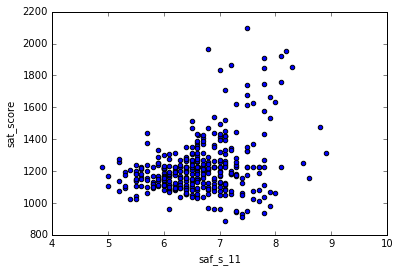

In [15]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

The relationship between perceived student safety marks and sat_scores is not consistently strong. That said, we see greater consistency in the extremes. Schools with low sat_scores generally have low safety scores. Likewise, schools with high sat_scores generally have high safety scores. 

That said, there are a few schools with high perceived student safety marks and relatively lower sat_scores.

Next we will compute and map out the average safety score for each school district. It is important to think in terms of boroughs when it comes to New York City.

In [16]:
# Compute the average safety score for each district
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
ave_safety_score_by_district = districts['saf_tot_11']
ave_safety_score_by_district.sample(5)

4     7.085714
31    7.383333
14    6.933333
13    7.435714
1     7.520833
Name: saf_tot_11, dtype: float64

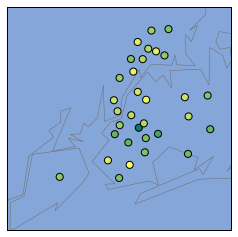

In [17]:
# Map average safety scores by district
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

latitudes = districts['lat'].tolist()
longitudes = districts['lon'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True,
         c=ave_safety_score_by_district, cmap='summer')

plt.show()

It is hard to draw definitive conlusions from the above plot. Parts of Brooklyn seem to have relatively lower safety scores.

Next let us turn to a consideration of race.

# Plot racial correlations
There are a few columns that together constitute the percentage of each race at a given school:
* white_per
* asian_per
* black_per
* hispanic_per

By plotting the correlation between these columns and *sat_score* we can determine whether there are any racial differences in SAT performance. Worth noting, these columns will not capture the situation where a child is of mixed race.

In [18]:
race_related_cols_with_sat_score = combined[['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']]
race_corr = race_related_cols_with_sat_score.corr()['sat_score']
race_corr = race_corr.iloc[0:-1]
race_corr

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

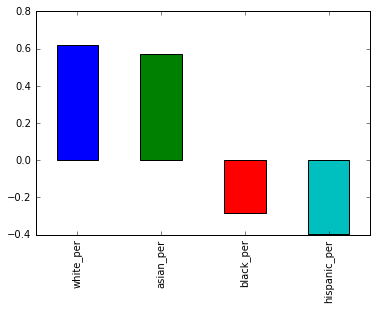

In [19]:
race_corr.plot.bar()
plt.show()

In terms of this chart the findings are relatively stark. If you are white or asian, you are more likely to have a relatively higher SAT score. If you are black or hispanic, you are more likely to have a relatively lower SAT score. 

Note: This chart does not cover the underlying factors behind the discrepancy. For example, poverty levels likely have a significant impact on SAT scores.

We will now research schools in which the hispanic percentage is greater than 95% to see what we can learn.

In [20]:
# Here is a sample of 5 schools in which the hispanic percentage is > 95%.
hispanic_schools = combined[combined['hispanic_per'] > 95]
hispanic_schools.sample(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10


Here are a few quick findings - based off Google and Wikipedia search results. Please note that the sample will have changed with a re-run of the Jupyter notebook and will likely not return these exact results.
* PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE - is open to students who have been in the United States for less than four years.
* ACADEMY FOR LANGUAGE AND TECHNOLOGY - Offers new immigrants the chance to learn computer programming and maintenance.
* MANHATTAN BRIDGES HIGH SCHOOL - Caters to immigrants recently arrived from Spanish-speaking countries. 
* WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL - Is located on the far upper West side. The school has an emphasis on trips and exploring the world.
* GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M... - Was founded to serve Spanish-speaking students.

A majority of these schools were built to serve recently arrived, Spanish-speaking immigrants.
As students may have only recently learned English and/ or have English as a second language, this may explain the relatively lower SAT scores.

Now let us consider schools with a hispanic percentage less than 10% and an average SAT score greater than 1800.

In [21]:
low_hispanic_per_high_sat_score = combined[(combined['hispanic_per'] < 10) &
                                   (combined['sat_score'] > 1800)]
low_hispanic_per_high_sat_score[['school_name', 'hispanic_per', 'sat_score']]

,school_name,hispanic_per,sat_score
37,Stuyvesant High School,2.4,2096.0
151,Bronx High School of Science,7.2,1969.0
187,Brooklyn Technical High School,7.9,1833.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0
356,Staten Island Technical High School,5.3,1953.0


Here are a few quick findings - based off Google and Wikipedia results:
* Stuyvesant High School - US News 2019 - Ranked 2nd in NY high schools
* Bronx High School of Science - US News 2019 - Ranked 5th in NY high schools
* Brooklyn Technical High School - US News 2019 - Ranked 10th in NY high schools
* Queens High School for the Sciences at York Co... - US News 2019 - Ranked 8th in NY high schools
* Staten Island Technical High School - US News 2019 - Ranked 7th in NY high schools

In short, according to US News all of these schools currently make the top ten list of high schools in New York state. These schools are known to be prestigious and hard to gain entrance to via testing. 

We see low hispanic diversity in all of these schools.  This is especially true at Stuyvesant High School, where only 2.4% of the student body identifies as Hispanic.

Next we will take a look at gender.

# Plot gender correlations

Two columns indicate the percentage of each gender at a school:
* male_per
* femal_per

We will now plot the correlations between each gender percentage and sat_score.

In [22]:
gender_with_sat_score = combined[['male_per', 'female_per', 'sat_score']]
gender_with_sat_score_corr = gender_with_sat_score.corr()['sat_score'][:-1]
gender_with_sat_score_corr

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

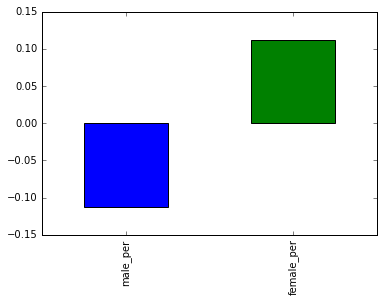

In [23]:
gender_with_sat_score_corr.plot.bar()
plt.show()

Relative to other factors, gender shows a relatively weak correlation to sat_scores. If anything, the directional difference (one positive and one negative) is interesting.

Here is a scatter chart showing female percentage vs sat_score:

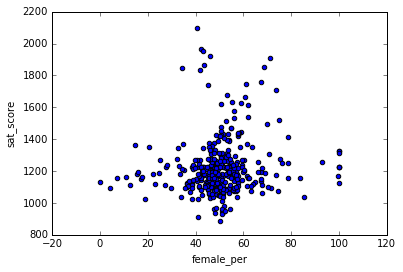

In [24]:
combined.plot.scatter('female_per', 'sat_score')
plt.show()

We do not see a strong relation between *female_per* and *sat_score*.

Now we will investigate schools with high SAT scores (> 1700) and a relatively high percentage of females (> 60%).

In [25]:

high_female_per_high_sat_score = combined[(combined['female_per'] > 60) &
                                          (combined['sat_score'] > 1700)]
high_female_per_high_sat_score

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


Here are a few quick findings - based off Google and Wikipedia results:
* BARD HIGH SCHOOL EARLY COLLEGE - Class sizes are small, homework heavy, and the high school curriculum is completed in the first two years.
* ELEANOR ROOSEVELT HIGH SCHOOL - Competition is fierce with 6,000 applications for 125 seats.
* BEACON HIGH SCHOOL - Students develop mastery of coursework via challenging projects. The school is exempt from administering all but the English Regents exam.
* FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A... - Is a famous 'Arts' school.
* TOWNSEND HARRIS HIGH SCHOOL - Emphasizes a well-rounded education.

Overall, we see an emphasis on schools that are not only competitive, but well-rounded in their scopes. It is interesting that LaGuaria High School is the only arts high school that made this list.

# Analysis of AP exams to sat scores
Last, we will turn to AP exams - used to earn college credits while in high school. In specific, we will analyze the percentage of students in each school who took at least one AP exam.

In [26]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

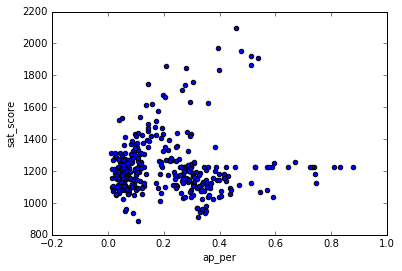

In [27]:
combined.plot.scatter('ap_per', 'sat_score')
plt.show()

The data may represent two inter-mingled subsets. For a subset of schools, AP percentage seems to have a semi-strong corrlelation with SAT scores. This relationship would need to be examined further.

# Conclusion

We have only taken a few small steps of many in terms of analyzing the relationship between demographics and SAT scores for New York City high schools. The results (especially in terms of race) demonstrate that further exploration of the data would be a worthwhile endeavor and would benefit from a rigorous statistical approach.